# Efecto de la radiación solar en las tasas de evaporación del almacenamiento de amoníaco

Para conocer el efecto de la radiación solar en las tasas de evaporación del almacenamiento de amoníaco, se debe primero, modelar dicho almacenamiento. En este caso, se asumirá que el tanque está inicialmente en equilibrio térmico con el ambiente y que se llenará de amoníaco dicho tanque, ya que a un llenado completo, es cuando hay mayores tasas de evaporación. 

Se tendrá una temperatura ambiente variable que oscila entre valores obtenidos de https://agrometeorologia.cl/ en la estación de Mejillones, lugar donde se tendrá un proyecto a gran escala de almacenamiento de amoníaco. Por lo que todos los datos se basarán en esta localización, incluyendo también la radiación incidente, obtenida a partir de https://solar.minenergia.cl/exploracion.

A continuación se presentan la ecuación gobernante y las condiciones de borde aplicadas para esta simulación. Teniendo como enfoque la pared aislante y los flujos de calor entrante y saliente.

## Ecuación Gobernante

$$ \rho C_p \frac{\partial T}{\partial t} = \frac{1}{r} \frac{\partial}{\partial r} (rk\frac{\partial T}{\partial r}) $$

## Condiciones de Borde

 En la pared interna, todo el calor que conduce el metal es transferido al líquido

$$ k \frac{\partial T}{\partial r}|_{r=r_i} = h_i (T|_{r=r_i}-T_{fluido}) $$

En la pared externa, el calor es transferido a los alrededores

$$ k \frac{\partial T}{\partial r}|_{r = r_o} = h_o(T_{aire}-T|_{r = r_o})$$

Las condiciones de borde de la temperatura son:
Temperatura inicial $$T_i = T_{aire}$$
Temperatura final $$ T_f = T_{fluido}$$

## Discretizado

Ecuación gobernante

$$ \rho C_p \frac{T^{j+1}_i-T^{j}_i}{\Delta t} = \frac{k}{r} (\frac{T^{j}_{i+1}-T^{j}_{i-1}}{2 \Delta r} + r \frac{T^{j}_{i+1}-2T_i^{j}+T^{j}_{i-1}}{\Delta r^2})  $$

Condiciones de borde

$$ k \frac{-3T_0 + 4 T_1 - T_2}{2\Delta r} = h_i (T_0-T_{fluido} )$$

$$ k \frac{3T_N - 4T_{N-1}+T_{N-2}}{2\Delta r} = h_o(T_{aire}-T_N) $$

### Se importan los módulos a utilizar

In [1]:
# Import modules
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import *
from scipy.integrate import simpson
# Mapas de colores
from matplotlib import cm


### Se definen los parámetros para la simulación a partir de datos realistas

In [2]:
# Definición de parámetros

# Radio interno
r_i = 29.74 # / m

# Aspect ratio
a = 0.533 # / razón óptima para las condiciones de operación

# Height
H = a * r_i * 2 # / m

# Espesor en pulgadas
thickness = 18 # / Espesor genérico para tanques de almacenamiento refrigerado

# Radio externo
r_o = r_i +thickness * 0.0254 # / m

# Densidad
rho = 60 # / kg/m3

# Calor específico
Cp = 900 # / J/kgK

# Coeficiente de transferencia de calor interno
h_i = 124.96 # / W/m2K obtenido a partir de correlaciones de VDI Heat Atlas
# h_i = 15 

# Coeficiente de transferencia de calor externo
h_o = 106.81 # / W/m2K obtenido a partir de correlaciones de VDI Heat Atlas


# Temperatura del fluido
T_fluido = -34 +273.15 # / K temperatura de saturación del amoníaco puro a presión atmosférica

# Temperatura del aire
T_aire = 16.8 +273.15 # /K temperatura promedio de Mejillones

# Conductividad térmica de la perlita (aislante)
k = 0.0411 # / W/mK

alpha = k / (rho*Cp)

Reescribimos

 $$ \frac{\rho C_p}{k} \frac{\partial T}{\partial t} = \frac{1}{r} ((\frac{r}{\Delta r^2}-\frac{1}{2\Delta r})T_{i-1}+(\frac{-2 r}{\Delta r^2})T_i + (\frac{r}{\Delta r^2}+\frac{1}{2\Delta r})T_{i+1}) $$

Las condiciones de borde:

$$(\frac{3k}{2\Delta r}+h_i)T_0-(\frac{4k}{2\Delta r})T_{1}+(\frac{k}{2\Delta r})T_{2} = h_iT_{fluido}$$

$$(\frac{k}{2\Delta r})T_{N-2}-(\frac{4k}{2\Delta r})T_{N-1}+(\frac{3k}{2\Delta r}+h_o)T_N = h_oT_{aire}$$

In [3]:
# Definir nodos 
n_x = 200

# Espaciamiento de tiempo
dt = 0.5 # s

# Temperatura inicial externa
T_0 = 16.8 + 273.15 # K

# Condición inicial igual a la temperatura del aire
T = np.ones(n_x) * T_0

# Tiempo inicial 
t_0 = 0 # s

# Tiempo final 
t_f = 3600*24 # s

# Grilla
x = np.linspace(r_i,r_o,n_x)

# Espacio en grilla uniforme
dx = (r_o-r_i)/(n_x-1)

In [4]:
# Matriz de coeficientes
A = np.zeros((n_x ,n_x))
b = np.zeros(n_x)

# Rellenar los nodos de la matriz
for i in range(1,n_x-1):
    # Coeficiente que multiplica a T_{i-1}
    A[i,i-1] = (1/x[i])*(x[i]/dx**2-1/(2*dx))

    #Coeficiente que multiplica a T_{i}
    A[i,i] = (-2/dx**2)

    # Coeficiente que multiplica a T_{i+1}
    A[i,i+1] = (1/x[i])*(x[i]/dx**2+1/(2*dx))

    # Vector del lado derecho
    b[i] = 0

# Condición de borde en r = r_i
A[0,0] = 3*k/(2*dx) + h_i
A[0,1] = -4*k/(2*dx)
A[0,2] = k/(2*dx)
b[0] = T_fluido*h_i

# Condición de borde en r = r_o
A[-1,-3] = k/(2*dx)
A[-1,-2] = -4*k/(2*dx)
A[-1,-1] = 3*k/(2*dx) + h_o
b[-1] = h_o*T_0


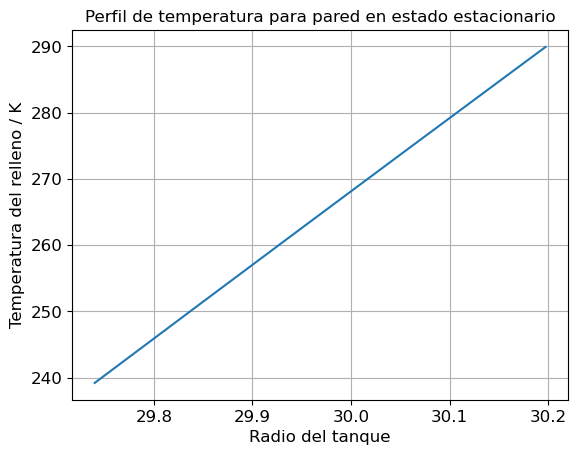

In [5]:
Graf = np.linalg.solve(A,b)
plt.figure()
plt.plot(x,Graf)
plt.xlabel('Radio del tanque', size = 12 )
plt.ylabel('Temperatura del relleno / K', size = 12)
plt.tick_params(labelsize = 12)
plt.title("Perfil de temperatura para pared en estado estacionario")
plt.grid()

In [6]:
T_new = T + (np.dot(A,T) + b) * dt /(rho*Cp)

T_new[-1] = (h_o * T_aire + T_new[-2] * (4*k / (2*dx)) - T_new[-3] * (k/(2*dx))) /(3*k/(2*dx) + h_o )


In [7]:
def declinacion(dia):
    """Declinación solar (grados) según el día del año, solo serviría si se modela a largo plazo"""
    return 23.45 * np.sin(np.radians((360/365)*(284 + dia)))

def G(t, lat=-23.11, dia=172): # Latitud Mejillones
    """
    Radiación solar incidente (W/m²), se ajustan los datos (t_sunrise, t_sunset y G_max) a partir del explorador solar y la 
    latitud dependiendo del lugar a analizar
    """
    lat = np.radians(lat)
    delta = np.radians(declinacion(dia))
    LME = 15*(round(lat/15))
    TSM = t + (LME-lat)/60
    B = 360/365*(dia-81)
    EoT = 9.87*np.sin(2*B)-7.53*np.cos(B)-1.5*np.sin(B)
    TS = TSM + EoT
    t_sunrise = 7
    t_sunset = 19
    G_max = 800
    
    G_base = np.where((t >= t_sunrise) & (t <= t_sunset),
                      G_max * np.sin(np.pi * (t - t_sunrise) / (t_sunset - t_sunrise)),
                      0) # Si se cumple que el tiempo está entre el tiempo de salida del sol y el tiempo de puesta del sol, se tiene dicha función
                        # para la radiación solar, para otros casos, la radiación es 0
    omega = np.radians(15 * (TS - 12)) # Ángulo horario
    alpha = np.arcsin(np.sin(lat)*np.sin(delta) + np.cos(lat)*np.cos(delta)*np.cos(omega)) # Ángulo solar
    # return G_base * np.maximum(np.sin(alpha), 0)
    return G_base

def G_pared_vertical(t, lat=-23.11, dia=172, rho=0.1, tau=0.0):
    """
    Radiación absorbida por una pared vertical.
    orientacion: azimut (0° = norte, +90° = este, -90° = oeste)
    rho: reflectividad
    tau: transmitancia
    alpha: absortividad (1 - rho - tau)
    """
    LME = 15*(round(lat/15))
    TSM = t + (LME-lat)/60
    B = 360/365*(dia-81)
    EoT = 9.87*np.sin(2*B)-7.53*np.cos(B)-1.5*np.sin(B)
    TS = TSM + EoT
    beta = np.radians(90)  # pared vertical, ángulo constante
    gamma = np.linspace(-np.pi, np.pi, t_f) # orientación que gira debido a que el manto del cilindro siempre tendrá alguna cara mirando al sol
    lat = np.radians(lat) # latitud, en el caso de Mejillones, -23.11
    delta = np.radians(declinacion(dia)) # inclinación de la tierra respecto al sol, importante si se modela por temporada y no solo de forma diaria
    omega = np.radians(15 * (TS - 12))
    
    # Radiación directa base
    G_dir = G(t, lat=np.degrees(lat), dia=dia)
    
    # Coseno del ángulo de incidencia, producto punto de vector solar y vector normal
    cos_theta = (
        np.sin(delta)*np.sin(lat)*np.cos(beta)
        - np.sin(delta)*np.cos(lat)*np.sin(beta)*np.cos(gamma)
        + np.cos(delta)*np.cos(lat)*np.cos(beta)*np.cos(omega)
        + np.cos(delta)*np.sin(lat)*np.sin(beta)*np.cos(gamma)*np.cos(omega)
        + np.cos(delta)*np.sin(beta)*np.sin(gamma)*np.sin(omega)
    )
    cos_theta = np.maximum(cos_theta, 0)
    
    # Radiación incidente sobre la pared
    G_inc = G_dir * cos_theta
    
    # Radiación absorbida por el material
    alpha = 1 - rho - tau
    G_abs = G_inc * alpha
    
    return G_abs



## Se introduce define la temperatura en función del tiempo de forma sinusoidal

In [8]:
def Temp(avg, time, range, freq, delay):
    # "avg" es la temperatura promedio a lo largo del plazo a evaluar (año, mes, semana, dia, etc)
    # "time" es el tiempo, la variable que afecta a la salida de la función
    # "range" es el rango de temperatura, Tmax-Tmin
    # "freq" es la frecuencia, de forma genérica, es 2pi/(unidad de tiempo, en este caso, 24 h), esto asumiendo que la temperatura no sufre grandes cambios de ciclo en ciclo
    # "delay" es el retardo que se le quiere aplicar en caso de que no se empiece en el tiempo 0, al implementar un valor distinto de 0
    #         al utilizar un valor no nulo, se debe de tener en cuenta que el retardo debe ser consistente en magnitud respecto a freq*time
    T = avg + range*math.sin(freq*time - delay)/2
    return T



In [9]:
import numpy as np

# Temperatura promedio en período a evaluar
avg_temp = 16.8 + 273.15 # K, en el caso de San Gregorio, evaluado para la semana del 17 al 24 de Abril 2024

# Temperatura máxima 
Tmax = 23.8 + 273.15 # K
# Tmax = avg_temp
# Tmin = avg_temp
# Temperatura mínima 
Tmin = 9.8 + 273.15 # K

# Rango
temp_range = Tmax - Tmin

# Frecuencia
freq = 2*np.pi / (24*3600)

# Retardo
delay = 0 # Evaluamos desde el tiempo 0

# Tiempo inicial de integración
t = 0

# Tiempo final de integración
t_max = 3600*24
# Tiempo inicial de graficación
tin = 3600*0 # s

#Tiempo final de graficación
tend = 3600*24 # s

# Intervalo de grabado de resultados
write_interval = 3600*4

# Lista en que se acumulan los tiempos grabados
t_vec = []

# Lista en que se acumulan los tiempos grabados
t_flux = []

# Copia de temperatura
T_old = np.copy(T)

# Lista con los perfiles de temperatura para cada write_interval
T_num = []

# Lista de diferenciales de calor externo
Qout = []

# Lista de diferenciales de calor interno
Qin = []

# Evolución de t0 a tmax
while t < t_max:
    ABS =  G_pared_vertical(t/3600, lat = -23.11, dia = 73, rho = 0.8, tau = 0)[0]
    # Iteración de nuevas temperaturas
    T_new = T_old + (np.dot(A, T_old) + b) * dt * alpha
    
    # Actualiza la temperatura de afuera
    T_new[-1] = ((h_o * Temp(avg_temp, t, temp_range, freq, delay) + T_new[-2] * (4 * k / (2 * dx)) - T_new[-3] * (k / (2 * dx))) / (3 * k / (2 * dx) 
                                                                                                                                     + h_o) + ABS/h_o )
        
    # Actualiza la temperatura de adentro
    T_new[0] = (h_i * T_fluido + T_new[1] * (4 * k / (2 * dx)) - T_new[2] * (k / (2 * dx))) / (3 * k / (2 * dx) + h_i)

    # Calor de la pared externa
    calorexterno = - k * ( 3*T_new[-1] - 4*T_new[-2] + T_new[-3]) /(2 *dx)
    Qout.append(calorexterno)
    
    # Calor de la pared interna
    calorinterno = k * ((-3)*T_new[0] + 4 * T_new[1] - T_new[2])/ (2 *dx)
    Qin.append(calorinterno)

    # Guarda tiempo en grilla temporal fina para gráfico de flux
    t_flux.append(t)
        
    # Avance de tiempo 
    t += dt

    T_old = np.copy(T_new)

    # Se guarda el perfil de temperatura y tiempo
    if (t % write_interval) < 0.9 * dt:
        T_num.append(np.copy(T_new))  # Ensure a copy of the array is stored
        # Guardamos el tiempo
        t_vec.append(t)
        
# print(T_new)


In [10]:
import numpy as np

# Temperatura promedio en período a evaluar
avg_temp = 16.8 + 273.15 # K, en el caso de San Gregorio, evaluado para la semana del 17 al 24 de Abril 2024

# Temperatura máxima 
Tmax = 23.8 + 273.15 # K
# Tmax = avg_temp
# Tmin = avg_temp
# Temperatura mínima 
Tmin = 9.8 + 273.15 # K

# Rango
temp_range = Tmax - Tmin

# Frecuencia
freq = 2*np.pi / (24*3600)

# Retardo
delay = 0 # Evaluamos desde el tiempo 0

# Tiempo inicial de integración
t = 0

# Tiempo final de integración
t_max = 3600*24
# Tiempo inicial de graficación
tin = 3600*0 # s

#Tiempo final de graficación
tend = 3600*24 # s

# Intervalo de grabado de resultados
write_interval = 3600*4

# Lista en que se acumulan los tiempos grabados
tsin_vec = []

# Lista en que se acumulan los tiempos grabados
tsin_flux = []

# Copia de temperatura
Tsin_old = np.copy(T)

# Lista con los perfiles de temperatura para cada write_interval
Tsin_num = []

# Lista de diferenciales de calor externo
Qsinout = []

# Lista de diferenciales de calor interno
Qsinin = []

# Evolución de t0 a tmax
while t < t_max:
    # Iteración de nuevas temperaturas
    Tsin_new = Tsin_old + (np.dot(A, Tsin_old) + b) * dt * alpha
    
    # Actualiza la temperatura de afuera
    Tsin_new[-1] = ((h_o * Temp(avg_temp, t, temp_range, freq, delay) + Tsin_new[-2] * (4 * k / (2 * dx)) - Tsin_new[-3] * (k / (2 * dx))) / (3 * k / (2 * dx) 
                                                                                                                                     + h_o))
        
    # Actualiza la temperatura de adentro
    Tsin_new[0] = (h_i * T_fluido + Tsin_new[1] * (4 * k / (2 * dx)) - Tsin_new[2] * (k / (2 * dx))) / (3 * k / (2 * dx) + h_i)

    # Calor de la pared externa
    calorexterno = - k * ( 3*Tsin_new[-1] - 4*Tsin_new[-2] + Tsin_new[-3]) /(2 *dx)
    Qsinout.append(calorexterno)
    
    # Calor de la pared interna
    calorinterno = k * ((-3)*Tsin_new[0] + 4 * Tsin_new[1] - Tsin_new[2])/ (2 *dx)
    Qsinin.append(calorinterno)

    # Guarda tiempo en grilla temporal fina para gráfico de flux
    tsin_flux.append(t)
        
    # Avance de tiempo 
    t += dt

    Tsin_old = np.copy(Tsin_new)

    # Se guarda el perfil de temperatura y tiempo
    if (t % write_interval) < 0.9 * dt:
        Tsin_num.append(np.copy(Tsin_new))  # Ensure a copy of the array is stored
        # Guardamos el tiempo
        tsin_vec.append(t)
        
# print(T_new)


C:\Users\minhs\AppData\Local\Temp\ipykernel_27344\1261111351.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cividis = cm.get_cmap("cividis", n_temp)


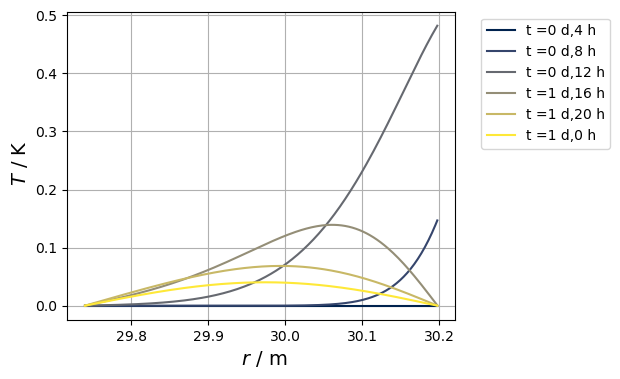

In [11]:
fig, ax = plt.subplots(1, 1, figsize = [5,4])
# Número de perfiles de temperatura totales a graficar
n_temp = len(T_num)
# Utilizar paleta de colores inclusiva
cividis = cm.get_cmap("cividis", n_temp)
#cividis = cm.colormaps.get_cmap("cividis", n_temp)

colour = [cividis(i/n_temp) for i in range(n_temp)]
# colours = [cividis(0), cividis(1 / 7), cividis(2 / 7), cividis(3 / 7), cividis(4 / 7), cividis
for k in range(len(T_num)):
    plt.plot(x, T_num[k]-Tsin_num[k], color = colour[k], label =  "t =%.0f d" % (t_vec[k]/3600/24)+","+"%.0f h" % ((t_vec[k]%(86400))/3600)) 
plt.xlabel(' $r$ / m', size = 14)
plt.ylabel(' $T$ / K', size = 14)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

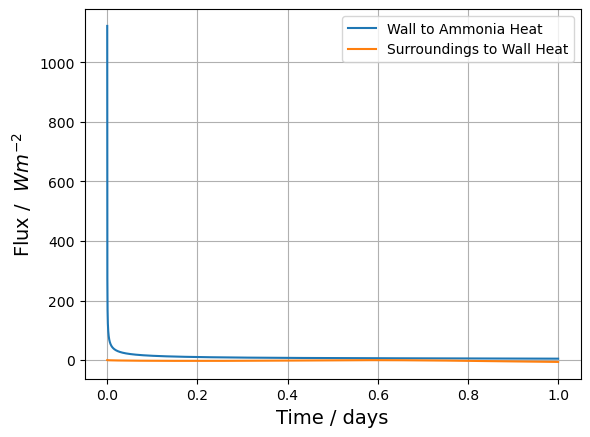

In [12]:
espesorcopy = range(len(Qin))
dias = []
for i in range(len(espesorcopy)):
    j = espesorcopy[i]/3600/24*dt
    dias.append(j)
plt.plot(dias, Qin, label = "Wall to Ammonia Heat")
plt.plot(dias, Qout, label = "Surroundings to Wall Heat")
plt.legend()
plt.grid()
plt.xlabel("Time / days", size = 14)
plt.ylabel("Flux /  $Wm^{-2}$", size = 14)
# plt.xlim([0.04,4])
# plt.ylim([-10,10])
plt.show()

In [13]:
tau_diff = (thickness * 0.0254)**2/(16 * alpha)
print("{:.2f}".format(tau_diff/3600) + " theorical hours to reach steady state")

4.77 theorical hours to reach steady state


C:\Users\minhs\AppData\Local\Temp\ipykernel_27344\1191064559.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cividis = cm.get_cmap("inferno", iris)


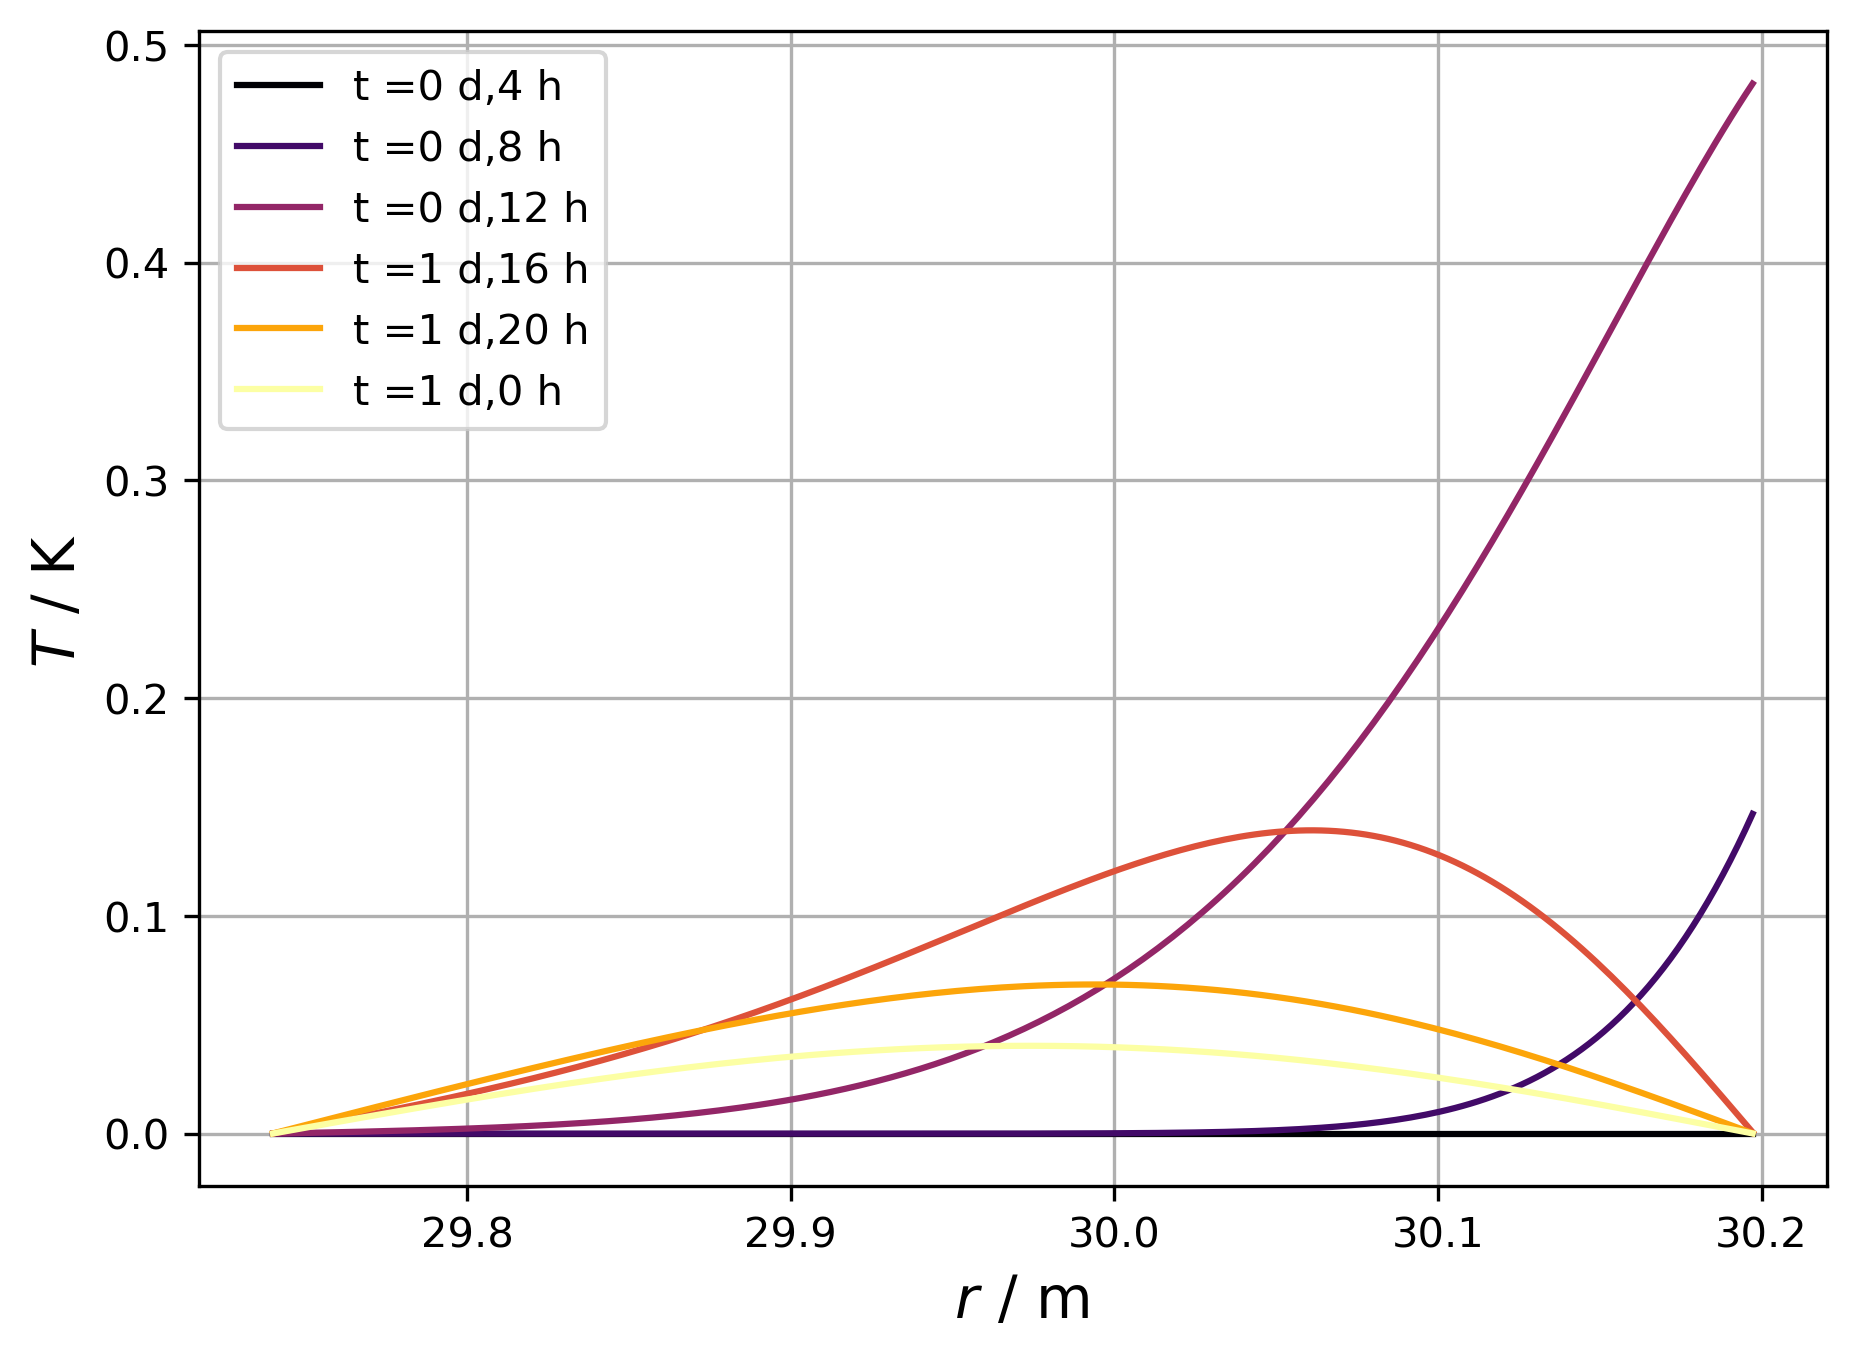

In [19]:
iris = int(tend/write_interval - tin/write_interval)
cividis = cm.get_cmap("inferno", iris)
colourpart = [cividis(i/iris) for i in range(iris)]
# colours = [cividis(0), cividis(1 / 7), cividis(2 / 7), cividis(3 / 7), cividis(4 / 7), cividis
fig, first = plt.subplots(figsize=[7, 5], dpi = 300)
for k in range(int(tin/write_interval), int(tend/write_interval)):
    first.plot(x, T_num[k] - Tsin_num[k], color = colourpart[k - int(tin/write_interval)], label =  "t =%.0f d" % (t_vec[k]/3600/24)+","+"%.0f h" % ((t_vec[k]%(86400))/3600)) 
first.set_xlabel(' $r$ / m', size = 14)
first.set_ylabel(' $T$ / K', size = 14)
first.grid()
# first.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
first.legend()
plt.savefig('Diferencia de Perfiles de temperatura Mejillones.svg', dpi = 300)
plt.show()

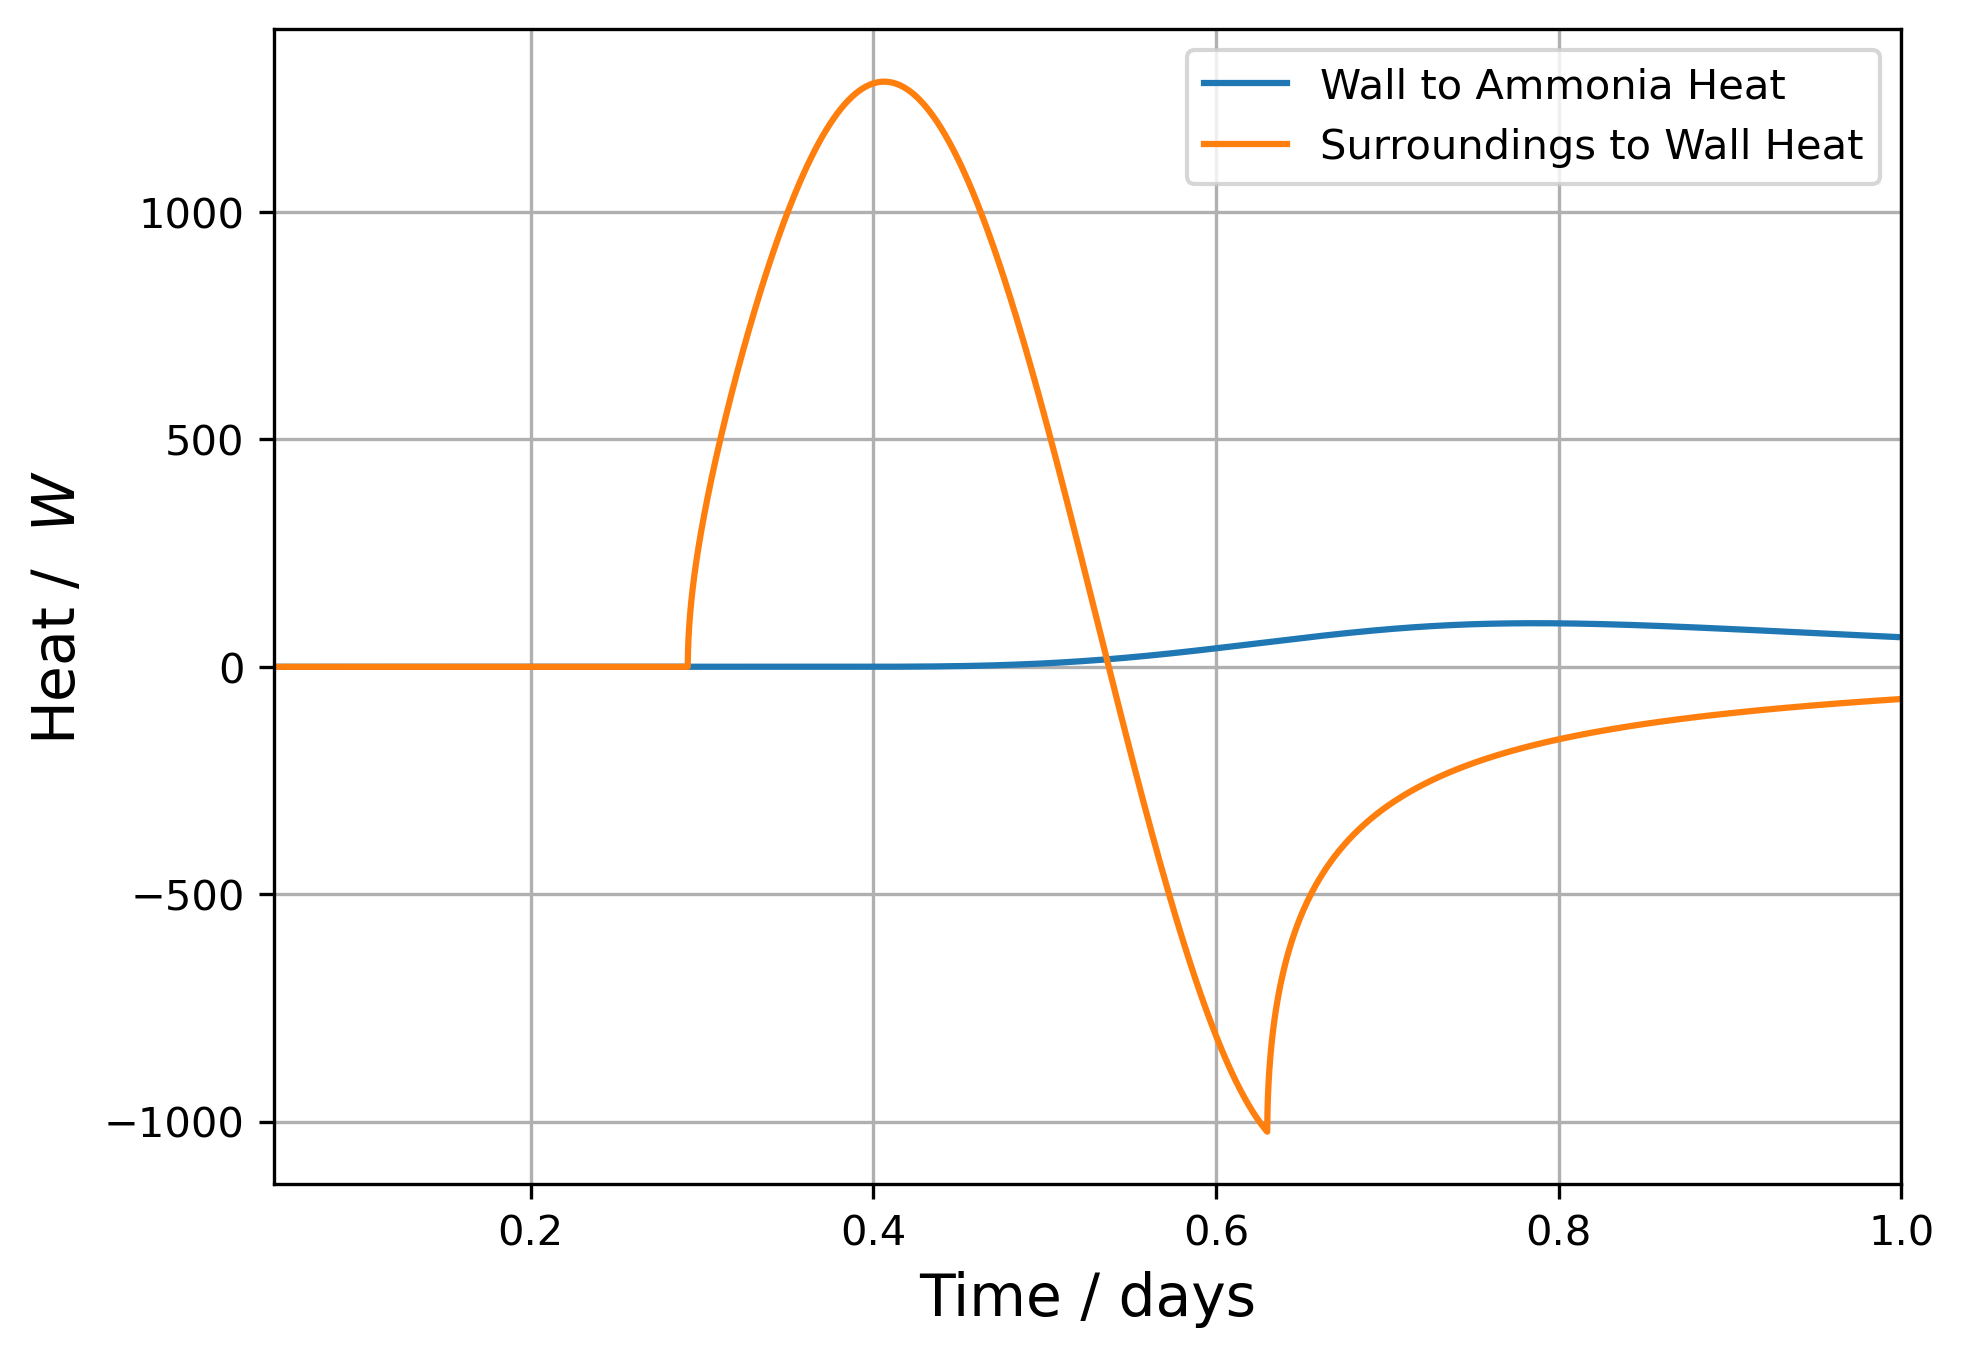

In [16]:
a_i = 2*np.pi*r_i*H
a_o = 2*np.pi*r_o*H

C_in = np.array(Qin)
C_in = C_in * a_i
C_out = np.array(Qout)
C_out = C_out * (-a_o)
Csin_in = np.array(Qsinin)
Csin_in = Csin_in * a_i
Csin_out = np.array(Qsinout)
Csin_out = Csin_out * (-a_o)
fig, second = plt.subplots(figsize=[7, 5], dpi = 300)
second.plot(dias[int(tin/dt):int(tend/dt)], C_in[int(tin/dt):int(tend/dt)] - Csin_in[int(tin/dt):int(tend/dt)], label = "Wall to Ammonia Heat")
second.plot(dias[int(tin/dt):int(tend/dt)], C_out[int(tin/dt):int(tend/dt)] - Csin_out[int(tin/dt):int(tend/dt)], label = "Surroundings to Wall Heat")
second.legend()
second.grid()
second.set_xlabel("Time / days", size = 14)
second.set_ylabel("Heat /  $W$", size = 14)
plt.xlim(0.05,1)
# plt.ylim(-0.025e6,0.12e6)
plt.savefig('Calor entrante Mejillones.svg', dpi = 300)
plt.show()
